In [1]:
%load_ext autoreload
%autoreload 2


import sys
import os

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier
from rlace import solve_adv_game

from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import warnings
import argparse
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import scipy
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
from rlace import init_classifier
from collections import Counter
from sklearn.linear_model import LogisticRegression
import rlace

In [2]:
bios_data_path = "../WWW/rlace/bios/data/bios_data"
bios_encodings_path = "../WWW/rlace/bios/data/encodings/freezed"

data = []
for mode in ["train", "dev", "test"]:
    with open(bios_data_path + "/" + "{}.pickle".format(mode), "rb") as f:
        data.append(pickle.load(f))
        
train,dev,test = data
gender2ind = {"m": 0, "f": 1}
train_profs, dev_profs = np.array([d["p"] for d in train]), np.array([d["p"] for d in dev])
train_gender, dev_gender = np.array([gender2ind[d["g"]] for d in train]), np.array([gender2ind[d["g"]] for d in dev])


data = []
for mode in ["train", "dev", "test"]:
    with open(bios_encodings_path + "/" + "{}_cls.npy".format(mode), "rb") as f:
        data.append(np.load(f))
        
train_x, dev_x, test_x = data
pca = PCA(n_components=300, random_state=0)
pca.fit(train_x)
train_x = pca.transform(train_x)
dev_x = pca.transform(dev_x)
test_x = pca.transform(test_x)

In [3]:
profs_counts = Counter(train_profs)
common_profs = [p for p,c in profs_counts.most_common(10)]
import itertools
pairs = []
for pair in itertools.product(common_profs, repeat=2):
    if (pair[0], pair[1]) not in pairs and (pair[1], pair[0]) not in pairs and pair[0] != pair[1]:
        pairs.append(pair)

In [4]:
random.seed(0)
np.random.seed(0)
idx = list(range(len(pairs)))
random.shuffle(idx)

pairs_sample = [pairs[i] for i in idx[:15]]

In [9]:
# load
with open("acl/interim/v_info.pickle", "rb") as f:
        v_info_linear_d, v_info_net_d, v_info_prof_clf_d = pickle.load(f)

In [10]:
pair=pairs_sample[0][0]+"-"+pairs_sample[0][1]
d_net = v_info_net_d[pair]
d_original = v_info_linear_d[pair]

try:
    df_net = pd.DataFrame(d_net)
except:
    df_net = pd.DataFrame({k:[v] for k,v in d_net.items()})
    
try:
    df_linear = pd.DataFrame(d_original)
except:
    df_linear = pd.DataFrame({k:[v] for k,v in d_original.items()}, index=range(5))

In [ ]:
thresholds = [0.55, 0.6, 0.65, 0.75,0.8,0.85,0.9,0.95,0.99]

Text(0.5, 1.0, 'professor-attorney')

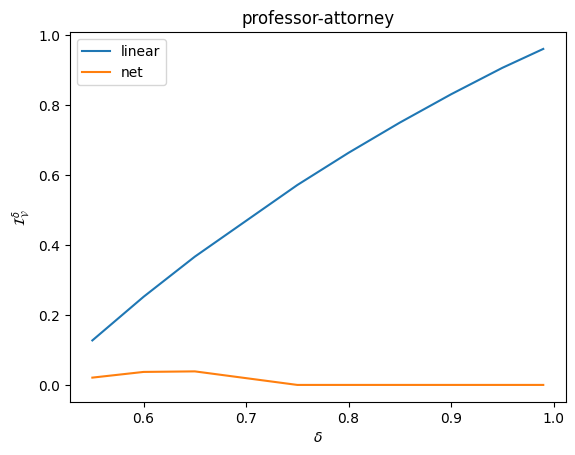

In [11]:
fig, ax = plt.subplots()

vals_linear = df_linear.head(1).to_numpy()*np.log2(np.e)
vals_net = df_net.to_numpy()*np.log2(np.e)
sn.lineplot(x=thresholds, y=vals_linear[0], label="linear")
sn.lineplot(x=thresholds, y=vals_net[0], label="net")
plt.xlabel("$\delta$")
plt.ylabel("$\mathcal{I}_{\mathcal{V}}^\delta$")
plt.title(pair)
#ax.figure.savefig("acl/plots/{}.pdf".format(pair), dpi = 700) 

In [12]:
def clean(df,axis_name="delta"):
    df = df.T
    df*=np.log2(np.e)
    df['avg'] = df.mean(numeric_only=True, axis=1)
    df["std"] = df.std(numeric_only=True, axis=1)
    df.rename_axis(axis_name, inplace=True)
    df.reset_index(inplace=True)
    return df

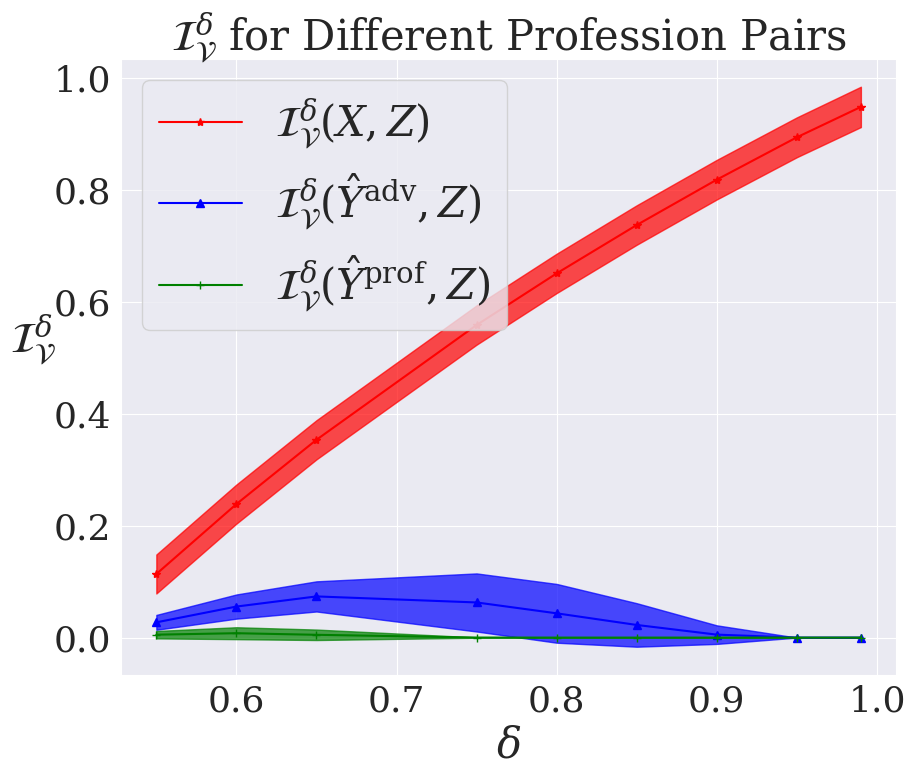

In [59]:

import seaborn as sbn
sbn.set_style("darkgrid")

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
# background grid using seaborn

fig, ax = plt.subplots()
all_profs = []
all_linear = []
all_net = []

profs_data = []
net_data = []
linear_data = []

all_net_data = []
all_linear_data = []
all_prof_data = []

for pair in pairs_sample[:]:
    
    pair = pair[0]+"-"+pair[1]
    d_net = v_info_net_d[pair]
    d_original = v_info_linear_d[pair]
    d_prof = v_info_prof_clf_d[pair]
    
    try:
        df_net = pd.DataFrame(d_net)
    except:
        df_net = pd.DataFrame({k:[v] for k,v in d_net.items()})
    
    try:
        df_linear = pd.DataFrame(d_original)
    except:
        df_linear = pd.DataFrame({k:[v] for k,v in d_original.items()}, index=range(5))
        
    try:
        df_prof = pd.DataFrame(d_prof)
    except:
        df_prof = pd.DataFrame({k:[v] for k,v in d_prof.items()}, index=range(5))

    df_net = clean(df_net)
    df_linear = clean(df_linear)
    df_prof = clean(df_prof)

    all_net_data.append(df_net["avg"].tolist())
    all_prof_data.append(df_prof["avg"].tolist())
    all_linear_data.append(df_linear["avg"].tolist())
    
    #vals_linear = (df_linear.to_numpy()*np.log2(np.e)).mean(axis=0)
    #vals_net = df_net.to_numpy()*np.log2(np.e)
    #vals_prof = (df_prof.to_numpy()*np.log2(np.e)).mean(axis=0)
    
    #sn.lineplot(thresholds, vals_linear, label="Original", color="red", yerr=vals_linear)
    #sn.lineplot(thresholds, vals_net[0], label="Adversarial", color="blue")
    #sn.lineplot(thresholds, vals_prof, label="prof", color="green")
    
    #df_linear.plot('delta', 'avg', yerr='std', ax=ax, label="linear", marker="*", color="red", alpha=0.7)
    #df_net.plot('delta', 'avg', yerr='std', ax=ax, label="Adversarial", marker="^", color="blue", alpha=0.7)
    #df_prof.plot('delta', 'avg', yerr='std', ax=ax, label="Prof", marker="+", color="green", alpha=0.7)


all_net_data = np.array(all_net_data)
all_linear_data = np.array(all_linear_data)
all_prof_data = np.array(all_prof_data)

plt.plot(thresholds, all_linear_data.mean(axis=0), label="Linear", marker="*", color="red")
plt.plot(thresholds, all_net_data.mean(axis=0), label="Adversarial", marker="^", color="blue")
plt.plot(thresholds, all_prof_data.mean(axis=0), label="Prof", marker="+", color="green")

plt.legend(["$\mathcal{I}_{\mathcal{V}}^{\delta}(X,Z)$", "$\mathcal{I}_{\mathcal{V}}^{\delta}(\hat{Y}^{\mathrm{adv}}, Z)$", 
            "$\mathcal{I}_{\mathcal{V}}^{\delta}(\hat{Y}^{\mathrm{prof}}, Z)$"], fontsize=30)


plt.fill_between(thresholds, all_linear_data.mean(axis=0)-all_linear_data.std(axis=0), all_linear_data.mean(axis=0)+all_linear_data.std(axis=0),
color = "red", alpha = 0.7)
plt.fill_between(thresholds, all_net_data.mean(axis=0)-all_net_data.std(axis=0), all_net_data.mean(axis=0)+all_net_data.std(axis=0),
color = "blue", alpha = 0.7)
plt.fill_between(thresholds, all_prof_data.mean(axis=0)-all_prof_data.std(axis=0), all_prof_data.mean(axis=0)+all_prof_data.std(axis=0),
color = "green", alpha = 0.7)



plt.xlabel("$\delta$", fontsize=30)
# make xticks and yticks larger and decrease xtick step size
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.ylabel("$\mathcal{I}_{\mathcal{V}}^{\delta}$", fontsize=30, rotation='horizontal', labelpad=15)
plt.title("$\mathcal{I}_{\mathcal{V}}^{\delta}$ for Different Profession Pairs", fontsize=30)

# increase figure size
fig.set_size_inches(10, 8)
ax.figure.savefig("acl/plots/binary_v2.pdf".format(pair), dpi = 2500) 

In [ ]:
hidden_sizes = [2,4,8,16,32,64]

In [ ]:
# with open("emnlp/interim/v_info_multiclass.pickle", "wb") as f:
#         pickle.dump(v_info_net_multiclass, f)

In [ ]:
with open("acl/interim/v_info_multiclass.pickle", "rb") as f:
        v_info_net_multiclass = pickle.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


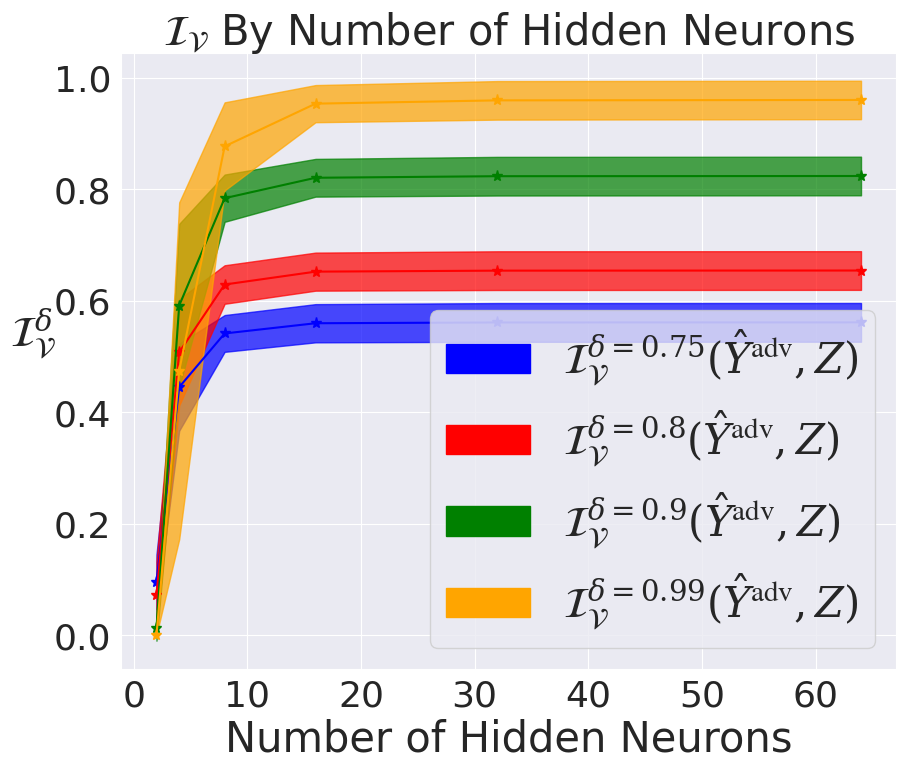

In [73]:
import seaborn as sbn
sbn.set_style("darkgrid")

fig, ax = plt.subplots()
all_net = []

# seaborn grid backgrou



all_all_data = []
plots = []

for thr,color in zip([0.75, 0.8, 0.9, 0.99],["blue", "red", "green", "orange"]):
    all_data = []

    for pair in pairs_sample[:]:
    
        pair = pair[0]+"-"+pair[1]
        d = defaultdict(dict)
        for pairname in pairs_sample:
            pair_str = pairname[0]+"-"+pairname[1]
            for size in hidden_sizes:
                d[pair_str][size] = v_info_net_multiclass[pair_str][size][thr]
    
        d = d[pair]
        try:
            df_net = pd.DataFrame(d)
        except:
            df_net = pd.DataFrame({k:[v] for k,v in d.items()})
    
        df_net = clean(df_net, axis_name="Number of Classes")

        #df_net.plot('Number of Classes', 'avg', yerr="std", ax=ax, marker="+", color=color, alpha=0.5,
        #            label="$\delta={}$".format(thr), markersize=8)

        all_data.append(df_net["avg"])
    
    all_data = np.array(all_data)
    plt.plot(hidden_sizes, all_data.mean(axis=0), marker="*", color=color, alpha=1.0, markersize=8)
    #plots.append(p)
    plt.fill_between(hidden_sizes, all_data.mean(axis=0)-all_data.std(axis=0), all_data.mean(axis=0)+all_data.std(axis=0),
color = color, alpha = 0.7)


plt.xlabel("Number of Hidden Neurons", fontsize=30)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.ylabel("$\mathcal{I}_{\mathcal{V}}^{\delta}$", fontsize=30, rotation='horizontal', labelpad=15)
plt.title("$\mathcal{I}_{\mathcal{V}}$ By Number of Hidden Neurons", fontsize=30)
plt.legend()
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label="$\mathcal{I}_{\mathcal{V}}^{\delta=0.75}(\hat{Y}^{\mathcal{adv}},Z)$")
red_patch = mpatches.Patch(color='red', label="$\mathcal{I}_{\mathcal{V}}^{\delta=0.8}(\hat{Y}^{\mathcal{adv}},Z)$")
green_patch = mpatches.Patch(color='green', label="$\mathcal{I}_{\mathcal{V}}^{\delta=0.9}(\hat{Y}^{\mathcal{adv}},Z)$")
orange_patch = mpatches.Patch(color='orange', label="$\mathcal{I}_{\mathcal{V}}^{\delta=0.99}(\hat{Y}^{\mathcal{adv}},Z)$")
plt.legend(handles=[blue_patch, red_patch, green_patch, orange_patch], fontsize=30)
# plt.legend(["$\mathcal{I}_{\mathcal{V}}^{\delta=0.75}(\hat{Y}^{\mathcal{adv}},Z)$",
#             "$\mathcal{I}_{\mathcal{V}}^{\delta=0.8}(\hat{Y}^{\mathcal{adv}},Z)$",
#             "$\mathcal{I}_{\mathcal{V}}^{\delta=0.9}(\hat{Y}^{\mathcal{adv}},Z)$",
#             "$\mathcal{I}_{\mathcal{V}}^{\delta=0.99}(\hat{Y}^{\mathcal{adv}},Z)$"], fontsize=30)
# leg = ax.get_legend()
# leg.legendHandles[0].set_color('blue')
# leg.legendHandles[1].set_color('red')
# leg.legendHandles[2].set_color('green')
# leg.legendHandles[3].set_color('orange')
# for line in leg.get_lines():
#     line.set_linewidth(4.0)

fig.set_size_inches(10, 8)

ax.figure.savefig("acl/plots/all-multiclass_v2.pdf".format(pair), dpi = 700) 